In [1]:
#preparing dataset
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import random


In [2]:
p=Path("../../Users/KIIT/images/")
dirs=p.glob("*")#iterating over all the folders in images folder using p.glob
labels_dict={"cat":0,"dog":1,"horse":2,"human":3}#mapping
image_data=[]
labels=[]
for folder_dir in dirs:
    #print(folder_dir)
    label=str(folder_dir).split("\\")[-1][:-1]#creating labels using the last word in folder name and getting labes as cat instead of cats
    #print(label)
    for img_path in folder_dir.glob("*.jpg"):#iterating over all the images in all folder
        #print(img_path)
        img=image.load_img(img_path,target_size=(32,32))#using load_img func in keras to load images
        img_array=image.img_to_array(img)#covert image to array using img_to_array using keras 
        image_data.append(img_array)
        labels.append(labels_dict[label])
        
    
    

In [3]:
image_data=np.array(image_data,dtype='float32')/255.0 #converted image_data to array
labels=np.array(labels)#converted labels to array
print(image_data.shape,labels.shape)

(808, 32, 32, 3) (808,)


In [4]:
#random shuffle the data
combined=list(zip(image_data,labels))
random.shuffle(combined)

#Unzip
image_data[:],labels[:]=zip(*combined)#* is used to unzip

In [5]:
##visualization
def draw(img):
    plt.imshow(img)
    
    plt.show()
    return

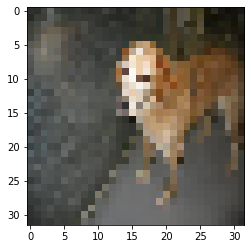

In [6]:
draw(image_data[0])

In [45]:
#Svm classifier
class SVM:
    def __init__(self,c=1.0):
        self.c=c
        self.W=0#weight
        self.b=0#bias
    def hingeLoss(self,W,b,X,Y):
        loss=0.0
        loss+=0.5+np.dot(W,W.T)
        m=X.shape[0]
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+b)
            loss+=self.c*max(0,(1-ti))
        return loss[0][0]
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        n=learning_rate
        c=self.c
        W=np.zeros((1,no_of_features))
        bias=0
        #print(self.hingeLoss(W,bias,X,Y))
        
        #train
        #weight and bias update
        losses=[]
        for i in range(maxItr):
            #training loop
            l=self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            #batch gradient descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #assume 0 gradient for the batch
                gradw=0
                gradb=0
                #iterate over all examples in mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T)+bias)
                        if ti>1:
                            gradw+=0
                            gradb+=0
                        else:
                            gradw+=c*Y[i]*X[i]
                            gradb+=c*Y[i]
                #update w and b
                W=W-n*W+n*gradw
                bias=bias+n*gradb
        self.W=W
        self.b=bias
        return W,bias,losses

In [46]:
## we need to convert data for one for one classification
##for n classes train nC2 classifier
m=image_data.shape[0]
image_data=image_data.reshape(m,-1)
classes=len(np.unique(labels))

In [47]:
def classWiseData(x,y):
    data={}
    for i in range(classes):
        data[i]=[]#empty list
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])#inserting data in respective classes
    for k in data.keys():
        data[k]=np.array(data[k])#converting values in data from list to arrays
    return data

In [48]:
data=classWiseData(image_data,labels)

In [49]:
def getDataPairForSVM(d1,d2):#d1 and d2 class should have labels as -1 and 1 for one for one classification no of classication should be nC2
    ##combines data of two classes into a single matrix
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    data_labels[:l1]=-1
    data_labels[l1:]=+1
    
    return data_pair,data_labels


In [102]:
#training nc2 svm part
mySVM=SVM()
def trainSVM(x,y):
    svm_classifiers={}#stores weights and bias for every pair we train
    for i in range(classes):
        svm_classifiers[i]={}
        for j in range(i+1,classes):
            xpair,ypair=getDataPairForSVM(data[i],data[j])
            wts,b,loss=mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j]=(wts,b)
            plt.plot(loss)
            plt.show()
    return svm_classifiers

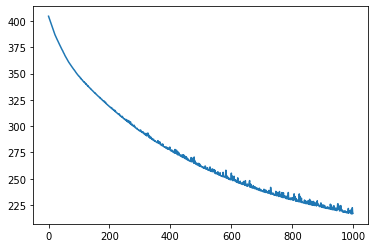

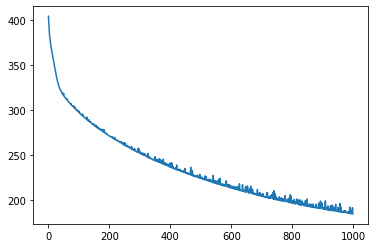

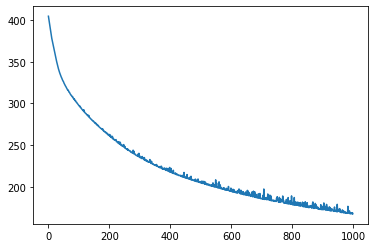

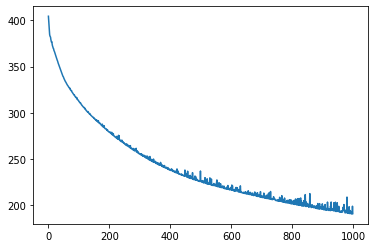

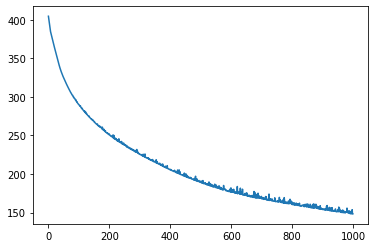

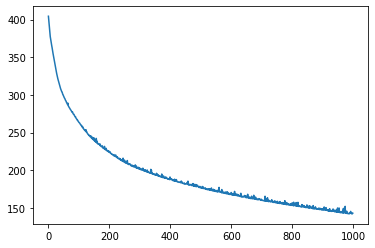

In [103]:
svm_classifiers=trainSVM(image_data,labels)

In [104]:
#cats_dogs=svm_classifiers[0][1]#parameters for cats and dogs
#print(cats_dogs[0].shape)
#print(cats_dogs[1])

In [105]:
#cats_humans=svm_classifiers[0][3]
#print(cats_humans[0])

In [106]:
def binarypredict(x,w,bias): #will predict as -1 or 1
    z=np.dot(x,w.T) +bias
    if z>=0:
        return 1
    else:
        return -1

In [107]:
#prediction
def predict(x):
    count=np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b=svm_classifiers[i][j]
            #majority prediction
            z=binarypredict(x,w,b)
            if z==1:#we trained the data as -1 and 1
                count[j]+=1
            else:
                count[i]+=1
    final_prediction=np.argmax(count)
    #print(count)
    return final_prediction
                

In [108]:
predict(image_data[0])


0

In [109]:
print(labels[0])

1


In [110]:
def accuracy(x,y):
    count=0
    for i in range(x.shape[0]):
        prediction=predict(x[i])
        if(prediction==y[i]):
            count+=1
    return count/x.shape[0]

In [111]:
acc=accuracy(image_data,labels)

In [112]:
acc

0.5866336633663366

In [113]:
#scikit

In [114]:
from sklearn import svm
svm_classifier=svm.SVC(kernel='linear',C=1.0)#c is penalty
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.6386138613861386